In [1]:

import pandas as pd
import numpy as np
import glob, os
import pickle

In [2]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


In [3]:
#path = r'csv_full_fingerprint' 

def csv_filepath(path,device_label):
    file_path=path+'/'+device_label+'/*.csv'
    all_files = glob.glob(file_path)
    return all_files

In [4]:
def save_model(model,outputdir,device_label):
    if not os.path.exists(outputdir):
        os.makedirs(outputdir)
    
    pickle_file = outputdir+'/model_'+device_label+'.sav'
    pickle.dump(model, open(pickle_file, 'wb'))
    print(device_label,' model saved'+'\n\n')
  

In [37]:
def combine_all_data(path,rows=12): # in iotsentinel number of packet is 12
    device_label=os.listdir(path)
    i=0
    j=0
    li = []
    while i < len(device_label):
        filepath = csv_filepath(path,device_label[i])
        for filename in filepath:
            df = pd.read_csv(filename, index_col=None,header=None, delimiter = '\t')
            df = df.iloc[:,:-1]      #exclude label column
            df = df.drop_duplicates() 
            df = df[:rows]           #select n uniques row
            
            if df.shape[0]<rows:     #fill with 0 if row less than n
                k = df.shape[0]
                while k < rows:   
                    temp = pd.DataFrame([[0 for i in range(len(df.columns))]], columns = df.columns)
                    df = df.append(temp)
                    k += 1
            df.reset_index(drop = True, inplace = True)
            
            #combine all rows into 1
            df=instances_combine(df,rows)
            
            #add label column
            df[df.shape[1]]=device_label[i]
            
            li.append(df)
            
            j+=1
            
        print('combined ',device_label[i],' csv files')
        i+=1
    print('all ',j,' files combined')
    frame = pd.concat(li, axis=0,ignore_index=True)
    return frame
        

In [6]:
#combine all rows into 1 instances
def instances_combine(df, rows):

    x=df.iloc[0].tolist()
    i=1
    
    while i < rows:
        y=df.iloc[i].tolist()
        x.extend(y)
        #print(len(x))
        i+=1
    ddf = pd.DataFrame(data = [x])
    return ddf


In [50]:

def change_label(df,device_label='Aria'):

    label_col = df.shape[1]-1
    df[label_col] = df[label_col].where(df[label_col]==device_label,other="Other")
    return df

def split_data(df):
    last=df.shape[1]-1
    X = df.loc[:,:last-1]
    y = df.loc[:,last]
    return X,y

In [52]:
def get_model():
    model = RandomForestClassifier(
        n_estimators=50,
        criterion='gini',
        max_depth=5,
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        max_features='auto',
        max_leaf_nodes=None,
        min_impurity_decrease=0.0,
        min_impurity_split=None,
        bootstrap=True,
        oob_score=False,
        n_jobs=-1,
        random_state=0,
        verbose=0,
        warm_start=False,
        class_weight='balanced'
    )
    return model

### Experiment IoT sentinel 
- load and combine csv file (each csv file  represent 1 fingerprint)
- filter n unique rows , n=12
- combine n rows into 1 instance with (n * 23) features
- return df shape(number of fingerprint, (n * 23) features)

In [38]:
inputdir = r'csv_full_fingerprint'
full_df = combine_all_data(inputdir,rows=12)

combined  Aria  csv files
combined  D-LinkCam  csv files
combined  D-LinkDayCam  csv files
combined  D-LinkDoorSensor  csv files
combined  D-LinkHomeHub  csv files
combined  D-LinkSensor  csv files
combined  D-LinkSiren  csv files
combined  D-LinkSwitch  csv files
combined  D-LinkWaterSensor  csv files
combined  EdimaxCam1  csv files
combined  EdimaxCam2  csv files
combined  EdimaxPlug1101W  csv files
combined  EdimaxPlug2101W  csv files
combined  EdnetCam1  csv files
combined  EdnetCam2  csv files
combined  EdnetGateway  csv files
combined  HomeMaticPlug  csv files
combined  HueBridge  csv files
combined  HueSwitch  csv files
combined  iKettle2  csv files
combined  Lightify  csv files
combined  MAXGateway  csv files
combined  SmarterCoffee  csv files
combined  TP-LinkPlugHS100  csv files
combined  TP-LinkPlugHS110  csv files
combined  WeMoInsightSwitch  csv files
combined  WeMoInsightSwitch2  csv files
combined  WeMoLink  csv files
combined  WeMoSwitch  csv files
combined  WeMoSwitch2

In [41]:
#full dataset info
print(full_df.shape)
print(len(full_df[full_df.shape[1]-1].unique())," IoT devices")
print(full_df[276].unique())
#full_df.head(2)



(550, 277)
31  IoT devices
['Aria' 'D-LinkCam' 'D-LinkDayCam' 'D-LinkDoorSensor' 'D-LinkHomeHub'
 'D-LinkSensor' 'D-LinkSiren' 'D-LinkSwitch' 'D-LinkWaterSensor'
 'EdimaxCam1' 'EdimaxCam2' 'EdimaxPlug1101W' 'EdimaxPlug2101W' 'EdnetCam1'
 'EdnetCam2' 'EdnetGateway' 'HomeMaticPlug' 'HueBridge' 'HueSwitch'
 'iKettle2' 'Lightify' 'MAXGateway' 'SmarterCoffee' 'TP-LinkPlugHS100'
 'TP-LinkPlugHS110' 'WeMoInsightSwitch' 'WeMoInsightSwitch2' 'WeMoLink'
 'WeMoSwitch' 'WeMoSwitch2' 'Withings']


In [42]:
#save full_df to csv
full_df.to_csv(r'dataset.csv', index=False, header=False)

In [51]:
from numpy import mean
from numpy import std
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score


inputdir = r'csv_full_fingerprint'

# load dataset
df = pd.read_csv(r'dataset.csv',header=None)

device_label=os.listdir(inputdir)

i=0
while i < len(device_label):
    # change label for others (device,others)
    df= change_label(df,device_label[i])
    X, y =split_data(df)
    # prepare the cross-validation procedure
    cv = StratifiedKFold(n_splits=10)
    # create model
    model = get_model()
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # report performance
    print('Accuracy for ',device_label[i],': %.3f (%.3f)' % (mean(scores), std(scores)))
    i += 1
    if i<len(device_label):
        df = pd.read_csv(r'dataset.csv',header=None)

Accuracy for  Aria : 0.964 (0.103)
Accuracy for  D-LinkCam : 0.989 (0.015)
Accuracy for  D-LinkDayCam : 0.975 (0.059)
Accuracy for  D-LinkDoorSensor : 1.000 (0.000)
Accuracy for  D-LinkHomeHub : 0.991 (0.015)
Accuracy for  D-LinkSensor : 0.944 (0.110)
Accuracy for  D-LinkSiren : 0.920 (0.204)
Accuracy for  D-LinkSwitch : 0.944 (0.145)
Accuracy for  D-LinkWaterSensor : 0.915 (0.226)
Accuracy for  EdimaxCam1 : 0.985 (0.021)


C:\Users\onewa\.conda\envs\test-env\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Accuracy for  EdimaxCam2 : 0.976 (0.042)
Accuracy for  EdimaxPlug1101W : 0.967 (0.053)
Accuracy for  EdimaxPlug2101W : 0.964 (0.069)
Accuracy for  EdnetCam1 : 0.980 (0.043)


C:\Users\onewa\.conda\envs\test-env\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Accuracy for  EdnetCam2 : 0.973 (0.056)
Accuracy for  EdnetGateway : 0.995 (0.008)
Accuracy for  HomeMaticPlug : 0.996 (0.007)
Accuracy for  HueBridge : 0.985 (0.016)
Accuracy for  HueSwitch : 1.000 (0.000)
Accuracy for  iKettle2 : 0.945 (0.114)
Accuracy for  Lightify : 0.996 (0.007)
Accuracy for  MAXGateway : 0.998 (0.005)
Accuracy for  SmarterCoffee : 0.953 (0.110)
Accuracy for  TP-LinkPlugHS100 : 0.947 (0.075)
Accuracy for  TP-LinkPlugHS110 : 0.975 (0.055)
Accuracy for  WeMoInsightSwitch : 0.993 (0.009)


C:\Users\onewa\.conda\envs\test-env\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Accuracy for  WeMoInsightSwitch2 : 0.996 (0.007)
Accuracy for  WeMoLink : 0.967 (0.081)
Accuracy for  WeMoSwitch : 0.996 (0.007)


C:\Users\onewa\.conda\envs\test-env\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Accuracy for  WeMoSwitch2 : 1.000 (0.000)
Accuracy for  Withings : 0.964 (0.103)


### Train for each device
- use all data

In [53]:
# train rf model for each device

inputdir = r'csv_full_fingerprint'
outputdir = 'classification_models'
device_label=os.listdir(inputdir)

df = pd.read_csv(r'dataset.csv',header=None)
i=0
while i < len(device_label):

    #path = csv_filepath(inputdir,device_label[i])
   
    print('Device: '+device_label[i]+'\n\n')

    df= change_label(df,device_label[i])
    X, y =split_data(df)

    # define outlier detection model
    model = get_model()
    
    # fit on all data
    model.fit(X,y)

    # save model
    save_model(model,outputdir,device_label[i])

    i += 1

    if i<len(device_label):
        df = pd.read_csv(r'dataset.csv',header=None)



Device: Aria


Aria  model saved


Device: D-LinkCam


D-LinkCam  model saved


Device: D-LinkDayCam


D-LinkDayCam  model saved


Device: D-LinkDoorSensor


D-LinkDoorSensor  model saved


Device: D-LinkHomeHub


D-LinkHomeHub  model saved


Device: D-LinkSensor


D-LinkSensor  model saved


Device: D-LinkSiren


D-LinkSiren  model saved


Device: D-LinkSwitch


D-LinkSwitch  model saved


Device: D-LinkWaterSensor


D-LinkWaterSensor  model saved


Device: EdimaxCam1


EdimaxCam1  model saved


Device: EdimaxCam2


EdimaxCam2  model saved


Device: EdimaxPlug1101W


EdimaxPlug1101W  model saved


Device: EdimaxPlug2101W


EdimaxPlug2101W  model saved


Device: EdnetCam1


EdnetCam1  model saved


Device: EdnetCam2


EdnetCam2  model saved


Device: EdnetGateway


EdnetGateway  model saved


Device: HomeMaticPlug


HomeMaticPlug  model saved


Device: HueBridge


HueBridge  model saved


Device: HueSwitch


HueSwitch  model saved


Device: iKettle2


iKettle2  model saved


Device: Li

## Device classificaiton
#### predict with other data/device

In [10]:
def sav_filepath(path):
    filepath=path+'/*.sav'
    all_files = glob.glob(filepath)
    return all_files

In [93]:
filename = 'classification_models'
print(sav_filepath(filename))

['classification_models\\model_Aria.sav', 'classification_models\\model_D-LinkCam.sav', 'classification_models\\model_D-LinkDayCam.sav', 'classification_models\\model_D-LinkDoorSensor.sav', 'classification_models\\model_D-LinkHomeHub.sav', 'classification_models\\model_D-LinkSensor.sav', 'classification_models\\model_D-LinkSiren.sav', 'classification_models\\model_D-LinkSwitch.sav', 'classification_models\\model_D-LinkWaterSensor.sav', 'classification_models\\model_EdimaxCam1.sav', 'classification_models\\model_EdimaxCam2.sav', 'classification_models\\model_EdimaxPlug1101W.sav', 'classification_models\\model_EdimaxPlug2101W.sav', 'classification_models\\model_EdnetCam1.sav', 'classification_models\\model_EdnetCam2.sav', 'classification_models\\model_EdnetGateway.sav', 'classification_models\\model_HomeMaticPlug.sav', 'classification_models\\model_HueBridge.sav', 'classification_models\\model_HueSwitch.sav', 'classification_models\\model_iKettle2.sav', 'classification_models\\model_Ligh

In [78]:
filename = 'classification_models/model_Aria.sav'
#load model
model = pickle.load(open(filename, 'rb'))
# detect outliers in the test set
yhat = model.predict(testX)

In [11]:
# performance measures
def performances(testy,yhat):
    score = f1_score(testy, yhat,pos_label=-1)
    acc= accuracy_score(testy,yhat)
    print('F1 Score: %.6f' % score)
    print('Accuracy Score: %.3f'% acc)
    print('Confusion matrix:')
    confusion_matrix(testy,yhat)

In [10]:
# mark inliers to 1 for testing
def label_inliers(label,y):
    
    y[y[:].isin([label])] = 1
    y[y[:].isin(['Other'])] = 0
    #y =y.astype('int64')
    return y

## Recursive feature elimination with cross-validation

Optimal number of features : 3


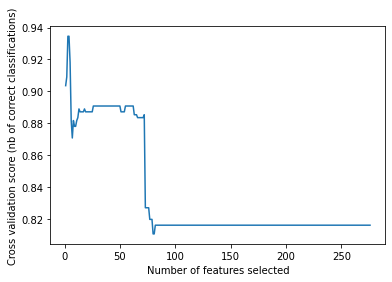

In [20]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

# Build a classification task using 3 informative features
X, y =split_data(df)

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy',
              min_features_to_select=min_features_to_select)
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

### Feature importance

In [57]:
df = pd.read_csv(r'dataset.csv',header=None)
df= change_label(df,'Aria')

X, y =split_data(df)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)

feature_names = [f'feature {i}' for i in range(X.shape[1])]

forest = get_model()
forest.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=50,
                       n_jobs=-1, random_state=0)

In [58]:
import time
import numpy as np

start_time = time.time()
importances = forest.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.017 seconds


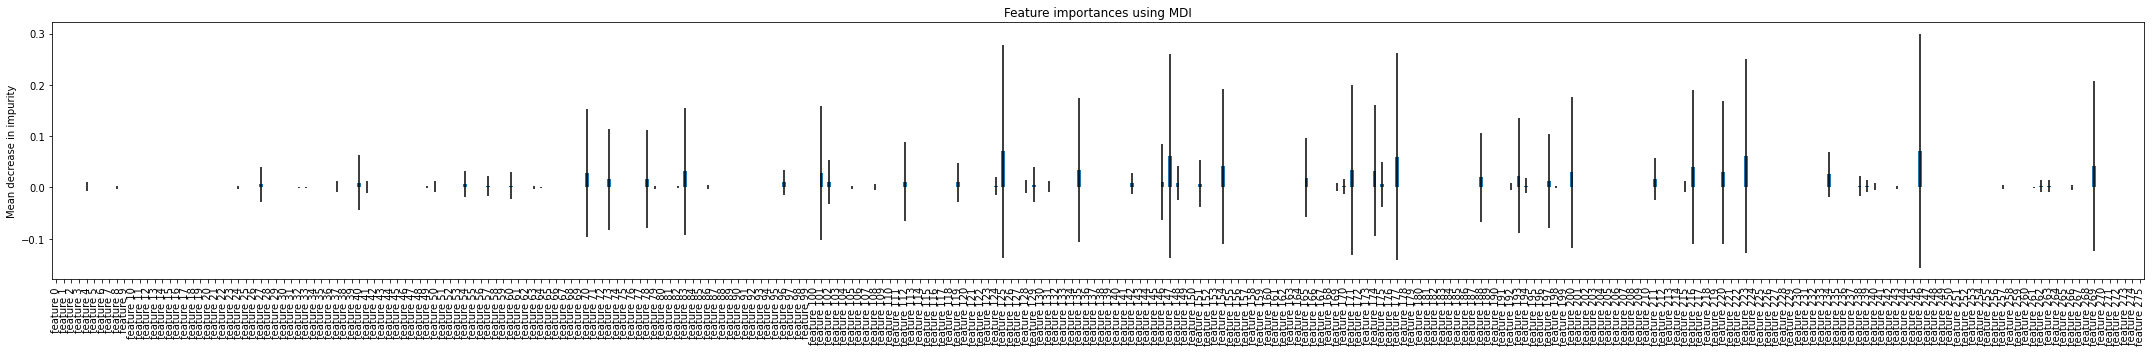

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
#matplotlib.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = (30,5)
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [82]:
forest_importances[forest_importances >0.02].sort_values(ascending=False) 

feature 246    0.071235
feature 125    0.070422
feature 223    0.061274
feature 147    0.060547
feature 177    0.060226
feature 269    0.041976
feature 154    0.040992
feature 216    0.038986
feature 171    0.034260
feature 135    0.034079
feature 174    0.032694
feature 83     0.031266
feature 200    0.030008
feature 220    0.029823
feature 101    0.028149
feature 70     0.028123
feature 234    0.025286
feature 193    0.022948
dtype: float64

In [107]:
headers_name=['Time_delta','ARP','LLC','EAPOL','Pck_size','Pck_rawdata','IP_padding','IP_ralert','IP_add_count','Portcl_src','Portcl_dst','ICMP','ICMP6','TCP','UDP','HTTPS','HTTP','DHCP','BOOTP','SSDP','DNS','MDNS','NTP','Label'] 


In [106]:
ft = [246,125,223,147,177,269,154,216,171,135,174,83,200,220,101,70,234,193]
ftr=[]
for i in ft:
    ftr.append(i%23)
    
print(ftr)
topft=np.unique(ftr)
print(topft)
for i in topft:
    print(headers_name[i])

[16, 10, 16, 9, 16, 16, 16, 9, 10, 20, 13, 14, 16, 13, 9, 1, 4, 9]
[ 1  4  9 10 13 14 16 20]
ARP
Pck_size
Portcl_src
Portcl_dst
TCP
UDP
HTTP
DNS
